*Technical University of Munich<br>
Professorship of Environmental Sensing and Modeling<br><br>*
**Author:**  Daniel Kühbacher<br>
**Date:**  07.10.2024

--- 

# Uncertainty of the single detector emission estimate

<!--Notebook description and usage information-->
TBD


In [39]:
import sys

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import scipy.stats as stats
import math

from datetime import time

sys.path.append('../../utils')
import data_paths
from hbefa_hot_emissions import HbefaHotEmissions
from hot_emission_process import process_hourly_emissions
from traffic_counts import TrafficCounts

In [2]:
# initialize hbefa 
hbefa_obj = HbefaHotEmissions()
# initialize traffic cycles
cycles = TrafficCounts()
# import visum data
visum_links = gpd.read_file(data_paths.VISUM_FOLDER_PATH + 'visum_links.gpkg')

Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_PC.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_LCV.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_HGV.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_Coach.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/EFA_HOT_Vehcat_MOT.XLS
Loaded emission factors from /Users/daniel_tum/Documents/projects/traffic inventory v2/traffic-emission-inventory/data/restricted_input/hbefa/ef_aggregated_los/EFA_HOT_Vehcat

# Import detector-based emissions for comparison

In [3]:
# import detector emission data
_fname = data_paths.INVENTORY_FOLDER_PATH + 'DetectorEmissions_2019_vc_estimate.feather'
_fname = data_paths.INVENTORY_FOLDER_PATH + 'DetectorEmissions_2019.feather'
df = pd.read_feather(_fname)

# Use Inventory Model to calculate the Emission

In [4]:
road_links_with_detectors = df['road_link_id'].unique()
visum_reduced = visum_links[visum_links['road_link_id']\
    .isin(road_links_with_detectors)].copy()
visum_reduced = visum_reduced.reset_index(drop=True).reset_index()

In [5]:
final_emissions = list()

for day in pd.date_range(start='2019-01-01', end= '2019-12-31', freq = 'd'): # for all days in 2019
    
    em_dict = process_hourly_emissions(day.strftime('%Y-%m-%d'),
                                        visum_reduced.to_dict('records'),
                                        cycles,
                                        hbefa_obj)
    
    df_temp = pd.DataFrame()
    for road_link_index, item in em_dict.items():
        
        data = pd.DataFrame(pd.Series(item).reset_index())
        data.rename(columns = {'level_0':'vehicle_class',
                               'level_1':'component',
                               'level_2':'hour',
                               0:'emission'},
                    inplace = True)
        data['date'] = day
        data['road_link_index'] = road_link_index
        df_temp = pd.concat([df_temp, data], axis = 0)
    final_emissions.append(df_temp)
model_dat = pd.concat(final_emissions)
model_dat['road_link_id'] = model_dat['road_link_index'].map(visum_reduced['road_link_id'].to_dict())
model_dat['timestamp'] = model_dat.apply(lambda row: pd.Timestamp.combine(row['date'],
                                                                          time(row['hour'])), axis = 1)

In [6]:
# serialize table
model_dat_long = model_dat.groupby(['vehicle_class',
                             'timestamp',
                             'road_link_id',
                             'component'])['emission'].sum().reset_index()

model_dat_long = model_dat_long.pivot(index = ['road_link_id', 'timestamp'],
                                      columns=['component', 'vehicle_class'],
                                      values = 'emission')

model_dat_long.head()

component                        BC (exhaust)       CH4        CO  \
vehicle_class                             BUS       BUS       BUS   
road_link_id timestamp                                              
38           2019-01-01 00:00:00     0.034896  0.002305  2.124496   
             2019-01-01 01:00:00     0.069793  0.004611  4.248992   
             2019-01-01 02:00:00     0.034896  0.002305  2.124496   
             2019-01-01 03:00:00     0.000000  0.000000  0.000000   
             2019-01-01 04:00:00     0.034896  0.002305  2.124496   

component                            CO2(rep)   CO2(total)         CO2e  \
vehicle_class                             BUS          BUS          BUS   
road_link_id timestamp                                                    
38           2019-01-01 00:00:00   592.828397   625.359209   612.936473   
             2019-01-01 01:00:00  1185.656793  1250.718417  1225.872945   
             2019-01-01 02:00:00   592.828397   625.359209   612.936473   
             2019-01-01 03:00:00     0.000000     0.000000     0.000000   
             2019-01-01 04:00:00   592.828397   625.359209   612.936473   

component                              NO2       NOx        PM BC (exhaust)  \
vehicle_class                          BUS       BUS       BUS          HGV   
road_link_id timestamp                                                        
38           2019-01-01 00:00:00  0.457933  4.654480  0.056336     0.460366   
             2019-01-01 01:00:00  0.915865  9.308961  0.112673     0.575457   
             2019-01-01 02:00:00  0.457933  4.654480  0.056336     0.460366   
             2019-01-01 03:00:00  0.000000  0.000000  0.000000     0.460366   
             2019-01-01 04:00:00  0.457933  4.654480  0.056336     0.460366   

component                         ...        PM BC (exhaust)       CH4  \
vehicle_class                     ...       MOT           PC        PC   
road_link_id timestamp            ...                                    
38           2019-01-01 00:00:00  ...  0.149722     1.189688  3.756381   
             2019-01-01 01:00:00  ...  0.149722     0.937458  2.959975   
             2019-01-01 02:00:00  ...  0.149722     0.626373  1.977741   
             2019-01-01 03:00:00  ...  0.000000     0.517073  1.632632   
             2019-01-01 04:00:00  ...  0.000000     0.466627  1.473351   

component                                 CO      CO2(rep)    CO2(total)  \
vehicle_class                             PC            PC            PC   
road_link_id timestamp                                                     
38           2019-01-01 00:00:00  408.070202  91375.480036  95831.688733   
             2019-01-01 01:00:00  321.553551  72002.586743  75514.016210   
             2019-01-01 02:00:00  214.849682  48109.351680  50455.553432   
             2019-01-01 03:00:00  177.359134  39714.431253  41651.228672   
             2019-01-01 04:00:00  160.055804  35839.852594  37587.694168   

component                                 CO2e        NO2         NOx  \
vehicle_class                               PC         PC          PC   
road_link_id timestamp                                                  
38           2019-01-01 00:00:00  92550.759918  41.801751  220.990403   
             2019-01-01 01:00:00  72928.690677  32.939189  174.137314   
             2019-01-01 02:00:00  48728.138614  22.008696  116.351838   
             2019-01-01 03:00:00  40225.241943  18.168252   96.048832   
             2019-01-01 04:00:00  36300.828095  16.395740   86.678215   

component                               PM  
vehicle_class                           PC  
road_link_id timestamp                      
38           2019-01-01 00:00:00  2.227193  
             2019-01-01 01:00:00  1.754997  
             2019-01-01 02:00:00  1.172621  
             2019-01-01 03:00:00  0.968003  
             2019-01-01 04:00:00  0.873563  

[5 rows x 45 columns]

# Prepare combined dataset

In [7]:
combined = pd.DataFrame()
for component in ['CO2(rep)', 'NOx', 'CO']:
    
    model = model_dat_long[component].sum(axis =1)
    model.name = f'model_{component}'
    detector = df.groupby(['road_link_id',
                          'timestamp'])[[f'{x}_{component}' for x in hbefa_obj.vehicle_classes]].sum().sum(axis=1)
    detector.name = f'detector_{component}'
    
    combined=pd.concat([combined, model, detector], axis = 1)
    
combined = combined.dropna()

# Calculate hourly differences

In [123]:
def normal(ax, mean, std, color="black"):
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = stats.norm.pdf(x, mean, std)
    z = ax.plot(x, p, color, linewidth=2)

In [151]:
def lognormal(ax, s, loc, scale,  color="black"):
    x = np.linspace(-1, 1.5, 200)
    p = stats.lognorm.pdf(x, s, loc = loc, scale = scale)
    z = ax.plot(x, p, color, linewidth=2, linestyle='--')

0.29559157286314686 0 1
0.2326785700703573 0 1
0.24270696856300888 0 1
0.3026832274020298 0 1
0.24473048861150637 0 1
0.261421717767836 0 1
0.3201865312095758 0 1
0.22692021466984147 0 1
0.20667897201841523 0 1


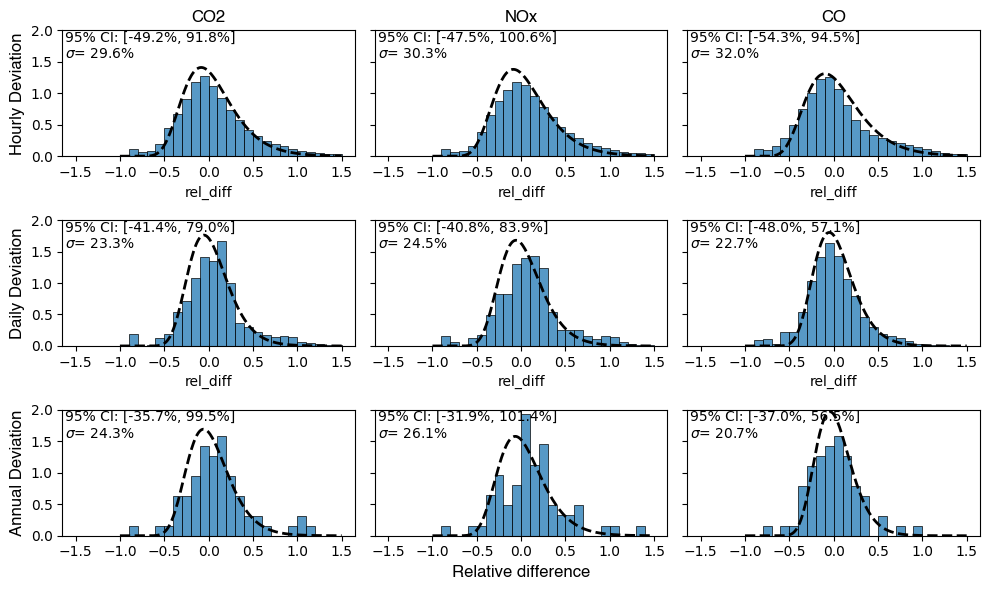

In [179]:
fig, ax = plt.subplots(3, 3, figsize = (10, 6), tight_layout = True, sharey = True)

col =0

for component in ['CO2(rep)', 'NOx', 'CO']:
    
    df_h = combined[[f'model_{component}', f'detector_{component}']].copy()
    df_d = df_h.reset_index(level = 0).groupby('level_0').resample('1d').sum()
    df_a = df_h.reset_index(level = 0).groupby('level_0').resample('1Y').sum()
    df_h['rel_diff'] = (df_h[f'model_{component}'] - df_h[f'detector_{component}'])/df_h[f'detector_{component}']
    df_d['rel_diff'] = (df_d[f'model_{component}'] - df_d[f'detector_{component}'])/df_d[f'detector_{component}']
    df_a['rel_diff'] = (df_a[f'model_{component}'] - df_a[f'detector_{component}'])/df_a[f'detector_{component}']
    
    val = df_h['rel_diff'][np.isfinite(df_h['rel_diff'].to_numpy())].to_numpy()
    (lb, ub) = (np.percentile(val, 5), np.percentile(val, 95))
    sub_val = val[(val>lb) & (val<ub)]
    s, loc, scale = stats.lognorm.fit((sub_val+1), floc=0, fscale =1)
    print(s, loc, scale)
    lognormal(ax[0,col], s, loc-1, 1)
    
    sns.histplot(df_h, x='rel_diff',  ax = ax[0, col], binrange=(-1.5,1.5), bins= 30, stat="density")
    text = f'95% CI: [{lb*100:.1f}%, {ub*100:.1f}%] \n$\sigma$= {s*100:.1f}%'
    ax[0,col].text(0.01, 0.78, text, transform=ax[0,col].transAxes)
    ax[0,col].set_ylim(0, 1.8)

    val1 = df_d['rel_diff'][np.isfinite(df_d['rel_diff'].to_numpy())].to_numpy()
    (lb1, ub1) = (np.percentile(val1, 5), np.percentile(val1, 95))
    sub_val1 = val1[(val1>lb1) & (val1<ub1)]
    s, loc, scale = stats.lognorm.fit((sub_val1+1), floc=0, fscale =1)
    print(s, loc, scale)
    lognormal(ax[1,col], s, loc-1, 1)
    sns.histplot(df_d, x='rel_diff',  ax = ax[1, col], binrange=(-1.5,1.5), bins= 30, stat="density")
    text = f'95% CI: [{lb1*100:.1f}%, {ub1*100:.1f}%] \n$\sigma$= {s*100:.1f}%'
    ax[1,col].text(0.01, 0.78, text, transform=ax[1,col].transAxes)
    ax[1,col].set_ylim(0, 1.8)
    
    val2 = df_a['rel_diff'][np.isfinite(df_a['rel_diff'].to_numpy())].to_numpy()
    (lb2, ub2) = (np.percentile(val2, 5), np.percentile(val2, 95))
    sub_val2 = val2[(val2>lb2) & (val2<ub2)]
    s, loc, scale = stats.lognorm.fit((sub_val2+1), floc=0, fscale =1)
    print(s, loc, scale)
    lognormal(ax[2,col], s, loc-1, 1)
    
    sns.histplot(df_a, x='rel_diff',  ax = ax[2, col], binrange=(-1.5,1.5), bins= 30, stat="density")
    text = f'95% CI: [{lb2*100:.1f}%, {ub2*100:.1f}%] \n$\sigma$= {s*100:.1f}%'
    ax[2,col].text(0.01, 0.78, text, transform=ax[2,col].transAxes)
    ax[2,col].set_ylim(0, 2)
    
    col+=1
    
    ax[0,0].set_ylabel('Hourly Deviation', font = 'Helvetica', fontsize = 12)
    ax[1,0].set_ylabel('Daily Deviation', font = 'Helvetica', fontsize = 12)
    ax[2,0].set_ylabel('Annual Deviation', font = 'Helvetica', fontsize = 12)
    
    ax[0,0].set_title('CO2', font = 'Helvetica', fontsize = 12)
    ax[0,1].set_title('NOx', font = 'Helvetica', fontsize = 12)
    ax[0,2].set_title('CO', font = 'Helvetica', fontsize = 12)
    
    ax[2,0].set_xlabel(' ')
    ax[2,2].set_xlabel(' ')
    ax[2,1].set_xlabel('Relative difference', fontsize = 12, font = 'Helvetica')
    

# Calculate Annual Differences

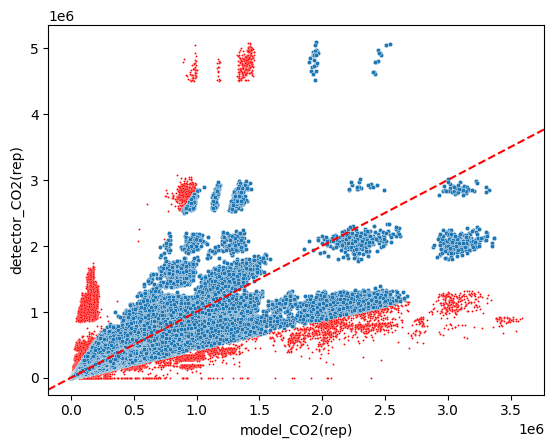

In [16]:
combined['rel_diff'] = (combined['model_CO2(rep)'] - combined['detector_CO2(rep)'])/combined['detector_CO2(rep)']
lb_test = np.percentile(combined['rel_diff'], 2.5)
ub_test = np.percentile(combined['rel_diff'], 97.5)

combined_sub = combined[(combined['rel_diff']>lb_test) & (combined['rel_diff']<ub_test)]
sns.scatterplot(data = combined, x='model_CO2(rep)', y='detector_CO2(rep)', s = 2, color = 'red')
sns.scatterplot(data = combined_sub, x='model_CO2(rep)', y='detector_CO2(rep)', s = 10)
plt.axline([0,0], [1,1], color = 'red', linestyle = '--')